# Example 10

## 3D case

**Content**

Example where the latent space is a $\emph{dense}$ vector. This notebook is for a single velocity model sample.

This notebook reproduces the first example of the paper. It consists of four main subheadings;

- Importing the *hcpinnseikonal* package functions
- Define the arguments for the input parameters
- Setup the medium and compute the data
- Training and inference

**Saving directory**

The notebook utilized [*wandb*](https://wandb.ai) for keeping track of the parameters and experiments. You can uncomment the *wandb* call to turn this feature off. Accordingly you need to specify the folder to save your experiment by changing the related *wandb* line inside the main function below.

## Import *hcpinnseikonal* package functions

In [17]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from argparse import ArgumentParser   
from scipy import interpolate

from hcpinnseikonal.utils import *
from hcpinnseikonal.model import *
from hcpinnseikonal.modeling3d import *
from hcpinnseikonal.plot import *
from hcpinnseikonal.arguments import *

args = parser.parse_args([])

args.use_wandb='n'
args.project_name='GFATT_PINNs-21-3d-field'

dict_args = vars(args)
print(dict_args)

# Change these lines for the wandb setup
if args.use_wandb=='y':
    wandb.init(project=args.project_name)
    wandb.run.log_code(".")
    wandb_dir = wandb.run.dir
else:
    args.save_folder='../saves/saves_latentLearningSingleDense'
    from pathlib import Path
    Path(args.save_folder).mkdir(parents=True, exist_ok=True)
    wandb_dir = args.save_folder
    
plt.style.use("~/science.mplstyle")

{'lateral_spacing': 0.01, 'vertical_spacing': 0.01, 'max_offset': 5.0, 'max_depth': 1.0, 'rec_spacing': 10, 'sou_spacing': 10, 'num_epochs': 250, 'num_neurons': 20, 'num_layers': 10, 'learning_rate': 0.001, 'model_type': 'seam', 'data_type': 'full', 'middle_shot': 'n', 'until_cmb': 'n', 'earth_scale': 'n', 'scale_factor': 10, 'reduce_after': 15, 'seed': 123, 'initialization': 'varianceScaling', 'plotting_factor': 1, 'rescale_plot': 'n', 'depth_shift': 'n', 'tau_multiplier': 3.0, 'initial_velocity': 4, 'zid_source': 5, 'zid_receiver': 0, 'explode_reflector': 'n', 'field_synthetic': 'n', 'v_multiplier': 3, 'activation': 'elu', 'num_points': 1.0, 'irregular_grid': 'n', 'xid_well': 5, 'last_vmultiplier': 5, 'v_units': 'unitless', 'well_depth': None, 'exp_function': 'n', 'exp_factor': 1.0, 'exclude_topo': 'n', 'exclude_well': 'n', 'exclude_source': 'n', 'loss_function': 'mse', 'station_factor': 1.0, 'event_factor': 1.0, 'checker_size': 5.0, 'tau_act': 'None', 'empty_middle': 'n', 'factoriza

## Define arguments

In [18]:
args.scale_factor=2 
args.until_cmb='y' 
args.num_epochs=1000
args.seed=1234 
args.learning_rate=5e-3
args.rescale_plot='y' 
args.initial_velocity=3 
args.zid_source=1 
args.zid_receiver=0 
args.data_type='full' 
args.irregular_grid='y' 
args.num_layers=12 
args.model_type='white2021' 
args.v_multiplier=6 
args.factorization_type='additive' 
args.tau_act='tanh' 
args.tau_multiplier=1 
args.max_offset=5
args.max_depth=1 #1.865625 
args.vertical_spacing=0.009375 
args.lateral_spacing=0.0375
args.num_neurons=24 
args.causality_factor=.5 

args.causality_weight='type_0' 
args.reduce_after=50 
args.field_synthetic='n' 
args.event_factor=0.9 
args.station_factor=0.2 
args.residual_network='y' 
args.empty_middle='n' 
args.regular_station='y' 
args.rec_spacing=10 
args.sou_spacing=30

args.plotting_factor=18.5
args.num_points=.6

args.sampling_rate=3

# args.num_layers=24
# args.num_neurons=24

dict_args=vars(args)
print(dict_args)

{'lateral_spacing': 0.0375, 'vertical_spacing': 0.009375, 'max_offset': 5, 'max_depth': 1, 'rec_spacing': 10, 'sou_spacing': 30, 'num_epochs': 1000, 'num_neurons': 24, 'num_layers': 12, 'learning_rate': 0.005, 'model_type': 'white2021', 'data_type': 'full', 'middle_shot': 'n', 'until_cmb': 'y', 'earth_scale': 'n', 'scale_factor': 2, 'reduce_after': 50, 'seed': 1234, 'initialization': 'varianceScaling', 'plotting_factor': 18.5, 'rescale_plot': 'y', 'depth_shift': 'n', 'tau_multiplier': 1, 'initial_velocity': 3, 'zid_source': 1, 'zid_receiver': 0, 'explode_reflector': 'n', 'field_synthetic': 'n', 'v_multiplier': 6, 'activation': 'elu', 'num_points': 0.6, 'irregular_grid': 'y', 'xid_well': 5, 'last_vmultiplier': 5, 'v_units': 'unitless', 'well_depth': None, 'exp_function': 'n', 'exp_factor': 1.0, 'exclude_topo': 'n', 'exclude_well': 'n', 'exclude_source': 'n', 'loss_function': 'mse', 'station_factor': 0.2, 'event_factor': 0.9, 'checker_size': 5.0, 'tau_act': 'tanh', 'empty_middle': 'n', '

## Latent Space Loading

In [3]:
from hcpinnseikonal.model import AutoEncoder

import pytorch_lightning as pl
import torchvision

# Dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,),(0.5,))
])

train_dataset = torchvision.datasets.ImageFolder('../data/random_fields/train/', transform=transform)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [39000, 1000])
test_set = torchvision.datasets.ImageFolder('../data/random_fields/test/', transform=transform)

# Dataloader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

latent_dim = 96

# Model
pretrained_filename = '../saved_models/random_fields/random_96/lightning_logs/version_3/checkpoints/epoch=28-step=4408.ckpt'
model = AutoEncoder.load_from_checkpoint(pretrained_filename)

# # PytorchLightning Trainer
# trainer = pl.Trainer(default_root_dir=os.path.join('../saved_models/random_fields/', f"random_{latent_dim}"), 
#         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
#         devices=1,
#         max_epochs=500, 
#         callbacks=[ModelCheckpoint(save_weights_only=True),
#                 GenerateCallback(get_train_images(8), every_n_epochs=10),
#                 LearningRateMonitor("epoch")])
# trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
# trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

# # Inference
# val_result = trainer.test(model, val_loader, verbose=False)
# test_result = trainer.test(model, test_loader, verbose=False)

train_vel = torch.load('../saved_models/random_fields/random_96/train_predvel.pt')
train_latent = torch.load('../saved_models/random_fields/random_96/train_latent.pt')

test_vel = torch.load('../saved_models/random_fields/random_96/test_predvel.pt')
test_latent = torch.load('../saved_models/random_fields/random_96/test_latent.pt')

Global seed set to 42


## Medium setup

Cuda installed! Running on GPU!
Device: cuda:0 Quadro RTX 8000
0 524288 torch.Size([524288])
Loading time: 0.05 minutes


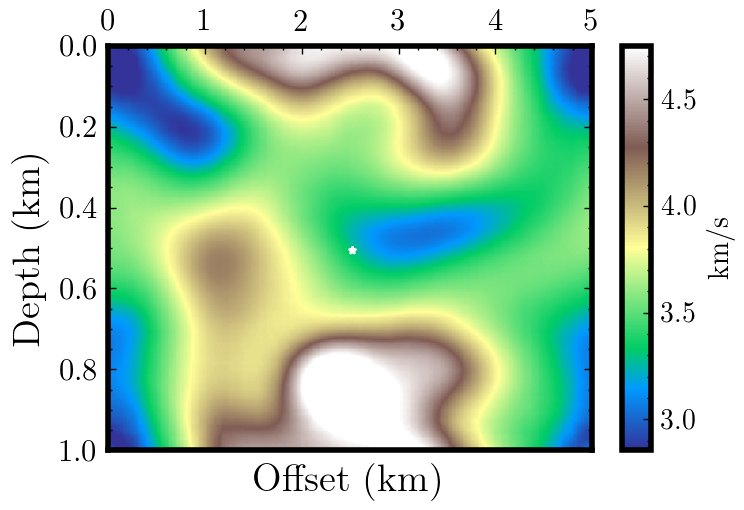

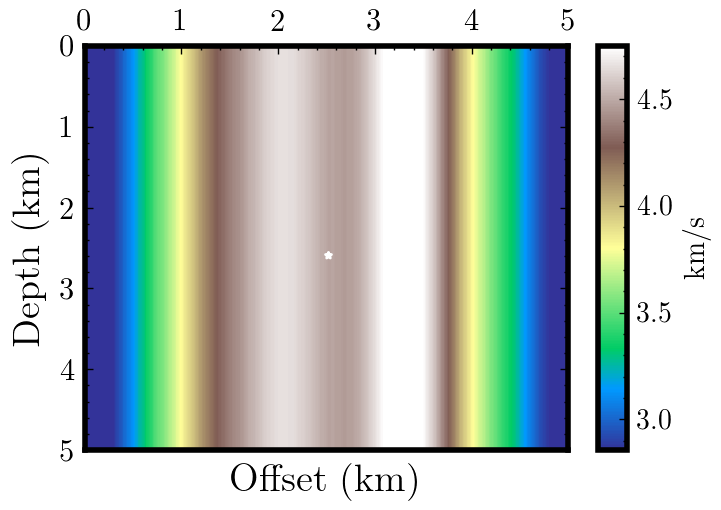

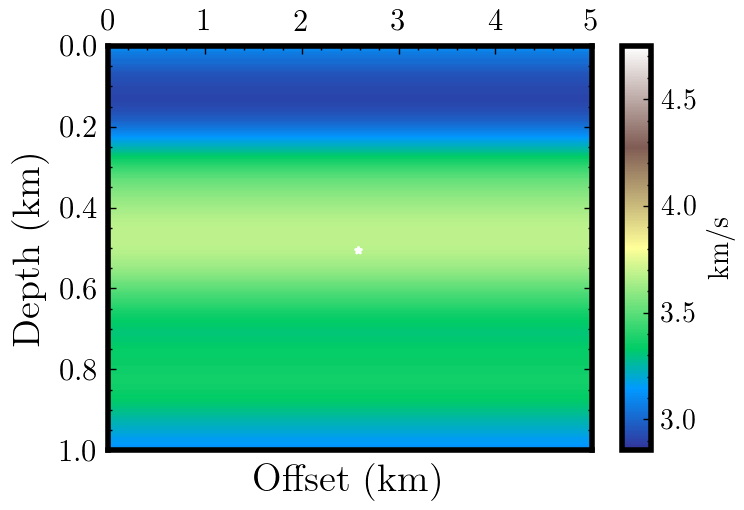

In [4]:
# Setup
if args.use_wandb=='y':
    wandb.config.update(args)

seed = args.seed

set_seed(seed)
device = set_device()

# Medium
data_type = args.data_type
deltar = args.rec_spacing
deltas = args.sou_spacing

# Computational model parameters
zmin = 0; zmax = args.max_depth; #deltaz = args.vertical_spacing;
ymin = 0.; ymax = args.max_offset; #deltay = args.lateral_spacing;
xmin = 0.; xmax = args.max_offset; #deltax = args.lateral_spacing;

if args.earth_scale=='y':
    earth_radi = 6371/args.scale_factor # Average in km
    xmin, xmax, deltax = earth_radi*xmin, earth_radi*xmax, earth_radi*deltax
    ymin, ymax, deltay = earth_radi*ymin, earth_radi*ymax, earth_radi*deltay
    zmin, zmax, deltaz = earth_radi*zmin, earth_radi*zmax, earth_radi*deltaz

z = np.linspace(zmin,zmax,128)
nz = z.size

y = np.linspace(ymin,ymax,32)
ny = y.size

x = np.linspace(xmin,xmax,128)
nx = x.size

Z,Y,X = np.meshgrid(z,y,x,indexing='ij')

deltax, deltay, deltaz = x[1]-x[0], y[1]-y[0], z[1]-z[0]

# Number of training points
        
# Sources indices
idx_all = np.arange(X.size).reshape(X.shape)
id_sou = idx_all[len(z)//2, len(y)//2, len(x)//2].reshape(-1)

sz = Z.reshape(-1)[id_sou]
sy = Y.reshape(-1)[id_sou]
sx = X.reshape(-1)[id_sou]

SX, SY, SZ = sx*np.ones_like(X), sy*np.ones_like(Y), sz*np.ones_like(Z)

vel = train_vel[-1]
# Augment a 3D velocity volume from 2D data
vel3d = np.repeat(vel[:, np.newaxis, :], len(y), axis=1)
    
# Extending the velocity model in thirs dimension byy repeatin the array
velmodel = np.repeat(vel3d[...,np.newaxis], sx.size,axis=2)

# ZX plane after
plot_section(vel3d[:,10,:], 'v_true_zx.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=X.reshape(-1)[id_sou],sz=Z.reshape(-1)[id_sou])

# XY plane
plot_section(vel3d[5,:,:], 'v_true_xy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
             sx=X.reshape(-1)[id_sou],sz=Y.reshape(-1)[id_sou])

# ZY plane
plot_section(vel3d[:,:,10], 'v_true_zy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y.reshape(-1)[id_sou],sz=Z.reshape(-1)[id_sou])

vs = 3 #km/s

T0 = np.sqrt((Z-SZ)**2 + (Y-SY)**2 + (X-SX)**2)/vs;
px0 = np.divide(X-SX, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)
py0 = np.divide(Y-SY, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)
pz0 = np.divide(Z-SZ, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)

# Locate source boolean
import time
start_time = time.time()

sids = id_sou

# Locate source boolean
isource = np.ones_like(X).reshape(-1,).astype(bool)
isource[sids] = False

velmodel = vel3d.reshape(-1,1)
px0 = px0.reshape(-1,1)
py0 = py0.reshape(-1,1)
pz0 = pz0.reshape(-1,1)
T0 = T0.reshape(-1,1)
index = idx_all.reshape(-1,1)

perm_id = np.random.permutation(X.size-sx.size)

input_wsrc = [X, Y, Z, SX, SY, SZ, T0, px0, py0, pz0, index]
input_wosrc = [i.ravel()[isource.reshape(-1)][perm_id] for i in input_wsrc]

# Network
lay = 'linear'
ini = args.initialization
bias = 0.2
mean = 0.01
std = 0.05
opttype = 'adam'
lr = args.learning_rate

torch.manual_seed(seed)
tau_model = ResidualNetwork(7, 1, num_neurons=args.num_neurons, 
                            num_layers=args.num_layers, act=args.activation, 
                            lay=lay, last_multiplier=args.tau_multiplier, 
                            last_abs=True)
tau_model.to(device)

if args.num_points<1:
    npoints = int(X.size * args.num_points)
    ipermute = np.random.permutation(np.arange(X.size))[:npoints]
else:
    ipermute = None

# Compute traveltime with randomly initialized network
pde_loader, ic = create_dataloader3dmodeling([i.ravel() for i in input_wsrc], sx, sy, sz,
                                   shuffle=False, batch_size=Z.size, fast_loader=True, perm_id=ipermute)

v_init = evaluate_velocity3d(tau_model, train_latent[0].to(device), pde_loader, Z.size, batch_size=Z.size, device=device)

elapsed = time.time() - start_time
print('Loading time: %.2f minutes' %(elapsed/60.))

# Optimizer
if opttype == 'adam':
    optimizer = torch.optim.Adam(list(tau_model.parameters()), lr=lr, betas=(0.9, 0.999), eps=1e-5)
elif opttype == 'lbfgs':
    optimizer = torch.optim.LBFGS(list(tau_model.parameters()), line_search_fn="strong_wolfe")

# Scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200,500,800], gamma=0.1)

## Training and Inference

Velocity #1
Epoch 0, Loss 0.4067126
Epoch 10, Loss 0.0926246
Epoch 20, Loss 0.0750003
Epoch 30, Loss 0.0718456
Epoch 40, Loss 0.0628663
Epoch 50, Loss 0.0569804
Epoch 60, Loss 0.0538469
Epoch 70, Loss 0.0458960
Epoch 80, Loss 0.0411039
Epoch 90, Loss 0.0373290
Epoch 100, Loss 0.0328577
Epoch 110, Loss 0.0331176
Epoch 120, Loss 0.0300924
Epoch 130, Loss 0.0338622
Epoch 140, Loss 0.0293115
Epoch 150, Loss 0.0279720
Epoch 160, Loss 0.0305252
Epoch 170, Loss 0.0233604
Epoch 180, Loss 0.0234887
Epoch 190, Loss 0.0232700
Epoch 200, Loss 0.0250219
Epoch 210, Loss 0.0209051
Epoch 220, Loss 0.0201452
Epoch 230, Loss 0.0222575
Epoch 240, Loss 0.0183763
Epoch 250, Loss 0.0168310
Epoch 260, Loss 0.0175163
Epoch 270, Loss 0.0181105
Epoch 280, Loss 0.0213600
Epoch 290, Loss 0.0229032
Epoch 300, Loss 0.0175327
Epoch 310, Loss 0.0187335
Epoch 320, Loss 0.0159125
Epoch 330, Loss 0.0159640
Epoch 340, Loss 0.0201243
Epoch 350, Loss 0.0161809
Epoch 360, Loss 0.0130488
Epoch 370, Loss 0.0167599
Epoch 380, 

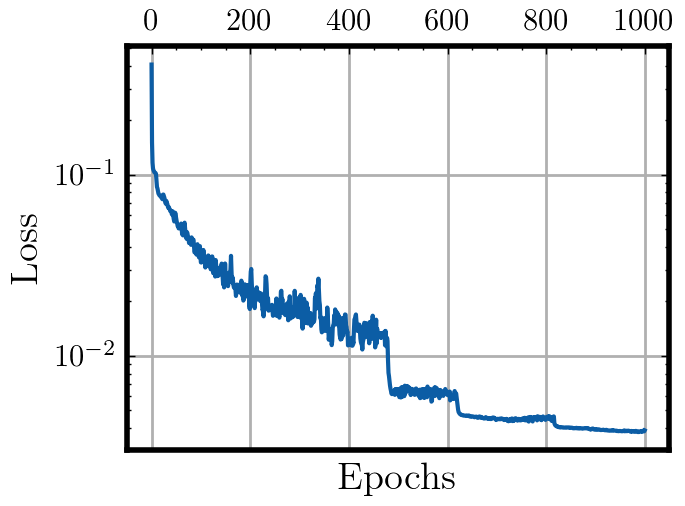

In [5]:
# Training
import time
start_time = time.time()

loss_history = \
    training_loop3d(
    input_wosrc, sx, sy, sz,
    tau_model, train_vel, train_latent, 
    optimizer, Z.size, npoints,
    out_epochs=args.num_epochs, 
    batch_size=Z.size//4, device=device, scheduler=scheduler, 
    fast_loader=True, args=dict_args, num_vel=1
)
elapsed = time.time() - start_time
print('Training time: %.2f minutes' %(elapsed/60.))

# Convergence history plot for verification
fig = plt.figure()
ax = plt.axes()
ax.semilogy(loss_history)
ax.set_xlabel('Epochs',fontsize=14)
plt.xticks(fontsize=11)
ax.set_ylabel('Loss',fontsize=14)
plt.yticks(fontsize=11);212
plt.grid()
plt.savefig(os.path.join(wandb_dir, "loss.pdf"), format='pdf', bbox_inches="tight")

# Save model
torch.save({
        'tau_model_state_dict': tau_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
}, wandb_dir+'/saved_model')

# To load
checkpoint = torch.load(wandb_dir+'/saved_model')
tau_model.load_state_dict(checkpoint['tau_model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Prediction
pde_loader, ic = create_dataloader3dmodeling([i.ravel() for i in input_wsrc], sx, sy, sz,
                                   shuffle=False, batch_size=Z.size, fast_loader=True, perm_id=ipermute)

v_pred = evaluate_velocity3d(tau_model, train_latent[0].to(device), pde_loader, Z.size, batch_size=Z.size, device=device)

tau_pred = evaluate_tau3d(tau_model, train_latent[0].to(device), pde_loader, Z.size, batch_size=Z.size, device=device)

v_pred = v_pred.detach().cpu().numpy()

## Playground

Cuda installed! Running on GPU!
Device: cuda:0 Quadro RTX 8000
0 524288 torch.Size([524288])


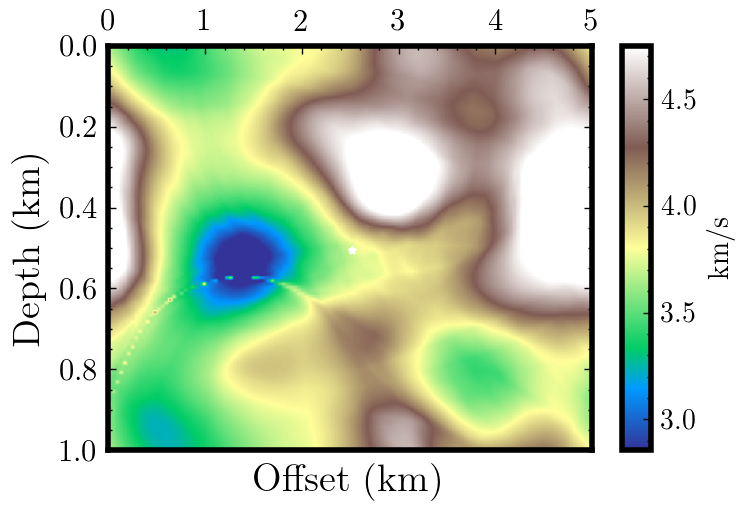

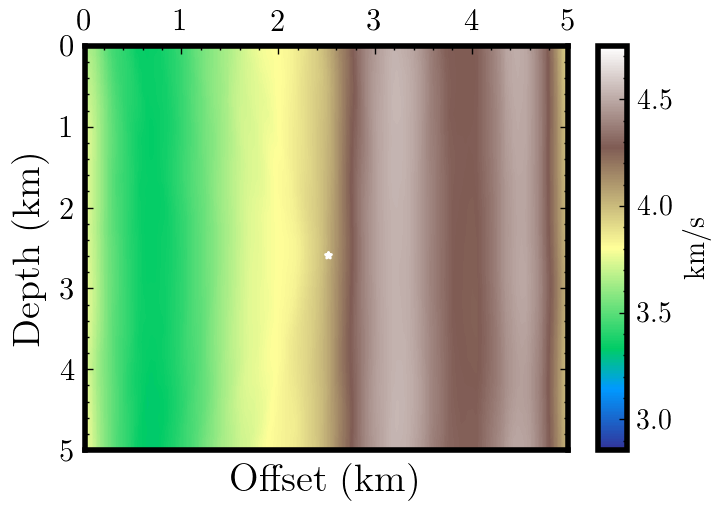

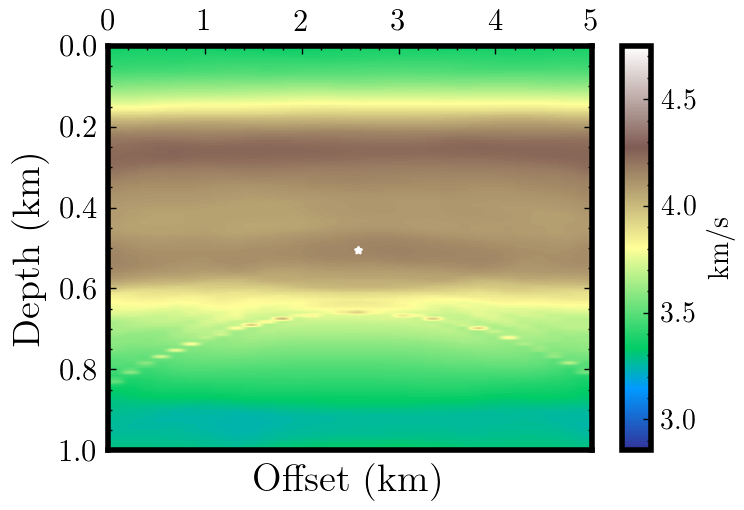

In [25]:
# Setup
if args.use_wandb=='y':
    wandb.config.update(args)

seed = args.seed

set_seed(seed)
device = set_device()

# Set sample index
vel_idx = 0
vel = train_vel[vel_idx]
# Augment a 3D velocity volume from 2D data
vel3d = np.repeat(vel[:, np.newaxis, :], len(y), axis=1)

# Save model
torch.save({
        'tau_model_state_dict': tau_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
}, wandb_dir+'/saved_model')

# To load
checkpoint = torch.load(wandb_dir+'/saved_model')
tau_model.load_state_dict(checkpoint['tau_model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# To load
checkpoint = torch.load(wandb_dir+'/saved_model')
tau_model.load_state_dict(checkpoint['tau_model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Prediction
pde_loader, ic = create_dataloader3dmodeling([i.ravel() for i in input_wsrc], sx, sy, sz,
                                   shuffle=False, batch_size=Z.size, fast_loader=True, perm_id=ipermute)

v_pred = evaluate_velocity3d(tau_model, train_latent[vel_idx].to(device), pde_loader, Z.size, batch_size=Z.size, device=device)

tau_pred = evaluate_tau3d(tau_model, train_latent[vel_idx].to(device), pde_loader, Z.size, batch_size=Z.size, device=device)

v_pred = v_pred.detach().cpu().numpy()

# ZX plane after
plot_section(v_pred.reshape(X.shape)[:,10,:], 'v_pred_zx.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=X.reshape(-1)[id_sou],sz=Z.reshape(-1)[id_sou])

# XY plane
plot_section(v_pred.reshape(X.shape)[5,:,:], 'v_pred_xy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
             sx=X.reshape(-1)[id_sou],sz=Y.reshape(-1)[id_sou])

# ZY plane
plot_section(v_pred.reshape(X.shape)[:,:,10], 'v_pred_zy.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y.reshape(-1)[id_sou],sz=Z.reshape(-1)[id_sou])

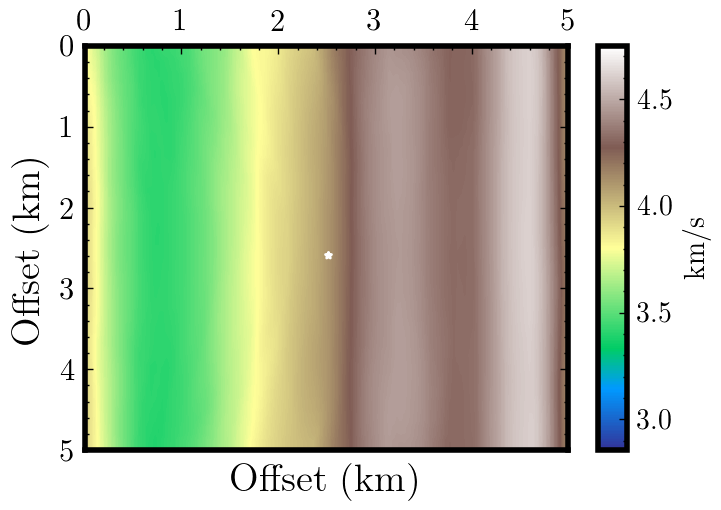

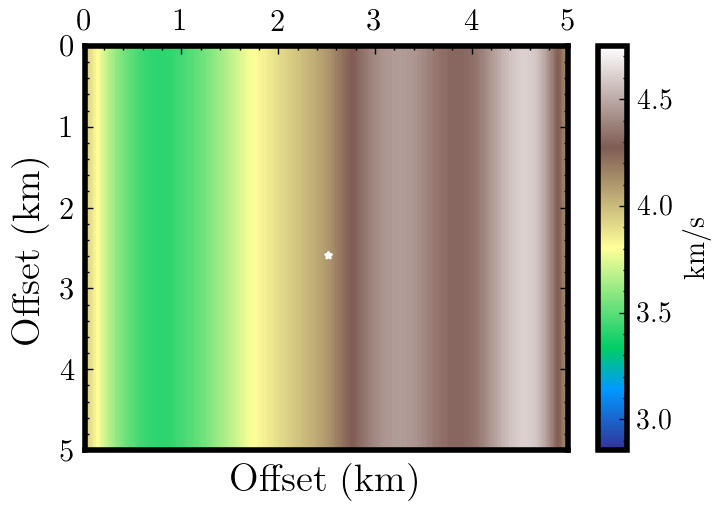

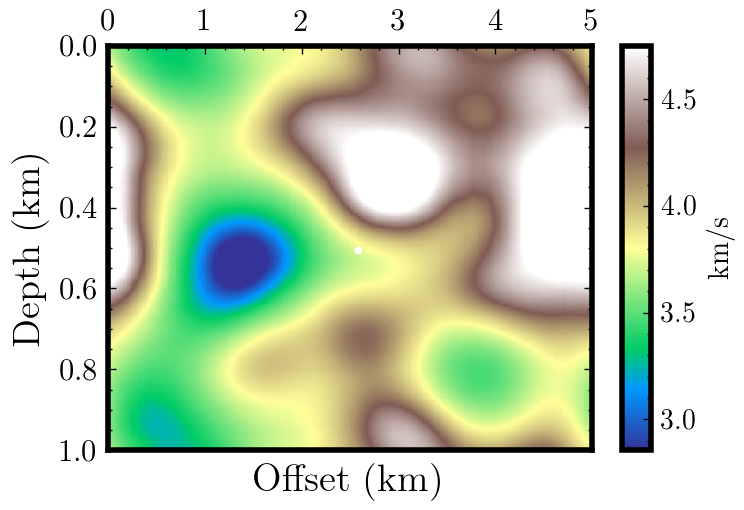

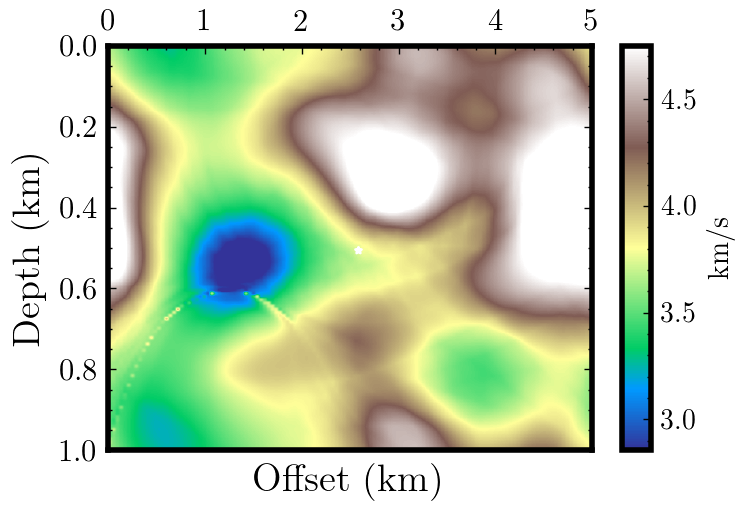

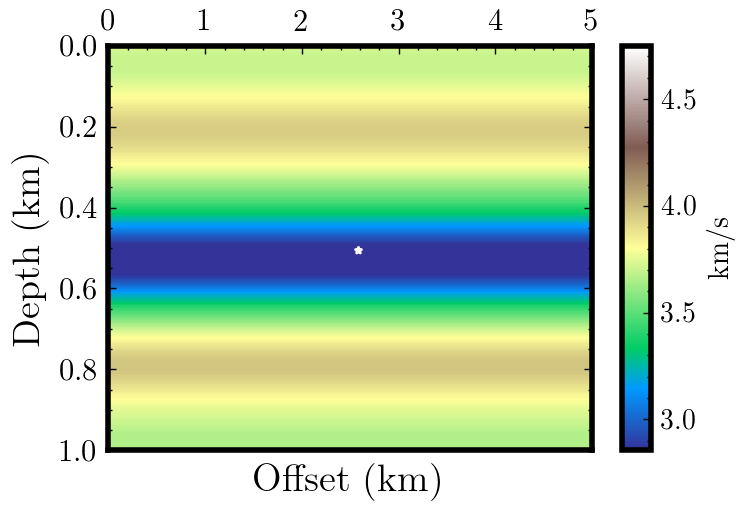

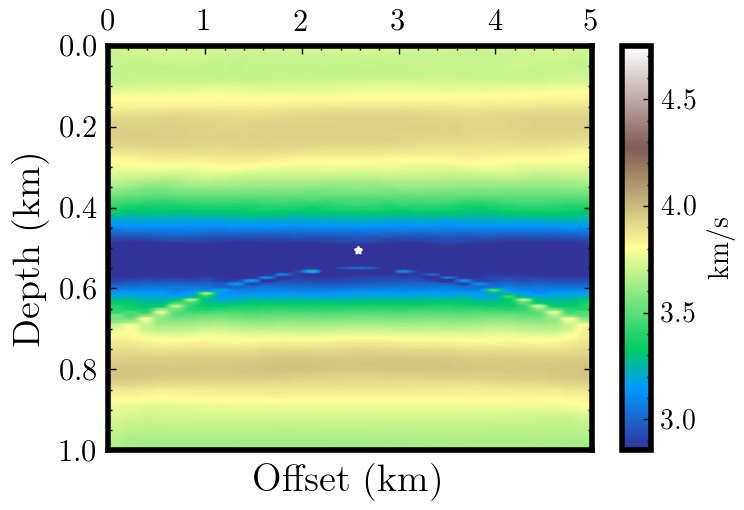

In [26]:
i=10
# XY plane
plot_depth(v_pred.reshape(X.shape)[i,:,:], 'v_pred_xy_z_'+str(round(z[i], 2))+'.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
             sx=X.reshape(-1)[id_sou],sz=Y.reshape(-1)[id_sou])

# XY plane
plot_depth(vel3d[i,:,:], 'v_true_xy_z_'+str(round(z[i], 2))+'.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=xmin, zmax=xmax, 
             sx=X.reshape(-1)[id_sou],sz=Y.reshape(-1)[id_sou])

j=5
# ZX plane
plot_section(vel3d[:,j,:], 'v_true_zx_y_'+str(round(y[j], 2))+'.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y.reshape(-1)[id_sou],sz=Z.reshape(-1)[id_sou])

# ZX plane
i=0
plot_section(v_pred.reshape(X.shape)[:,j,:], 'v_pred_zx_y_'+str(round(y[j], 2))+'.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y.reshape(-1)[id_sou],sz=Z.reshape(-1)[id_sou])

j=40
# ZY plane
plot_section(vel3d[:,:,j], 'v_true_zy_x_'+str(round(x[j], 2))+'.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y.reshape(-1)[id_sou],sz=Z.reshape(-1)[id_sou])

# ZY plane
plot_section(v_pred.reshape(X.shape)[:,:,j], 'v_pred_zy_x_'+str(round(x[j], 2))+'.pdf', vmin=np.nanmin(velmodel)+0.1, 
             vmax=np.nanmax(velmodel)-0.5, save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=Y.reshape(-1)[id_sou],sz=Z.reshape(-1)[id_sou])

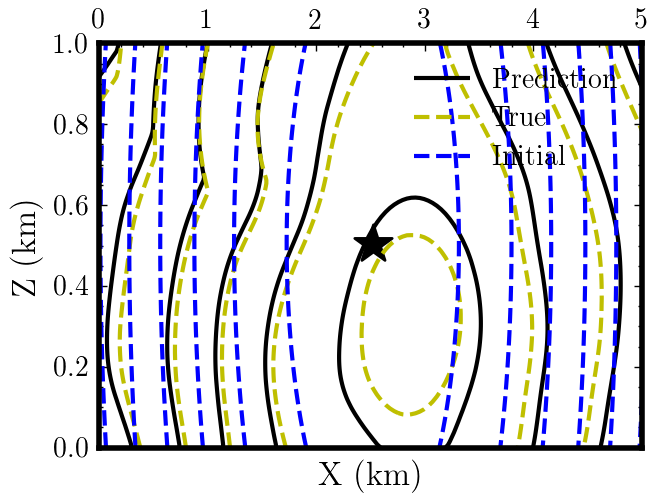

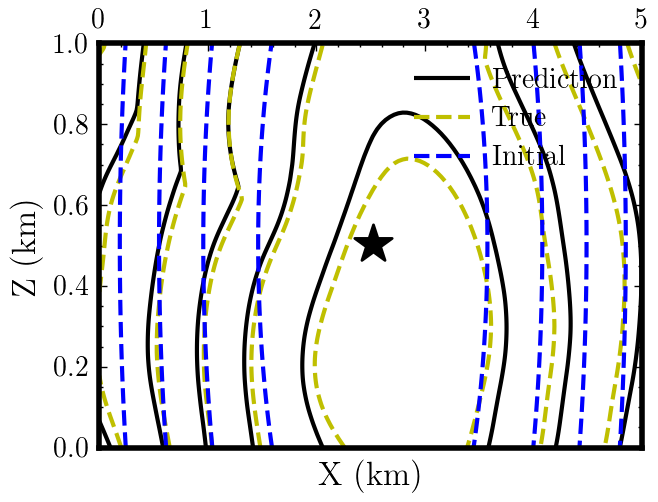

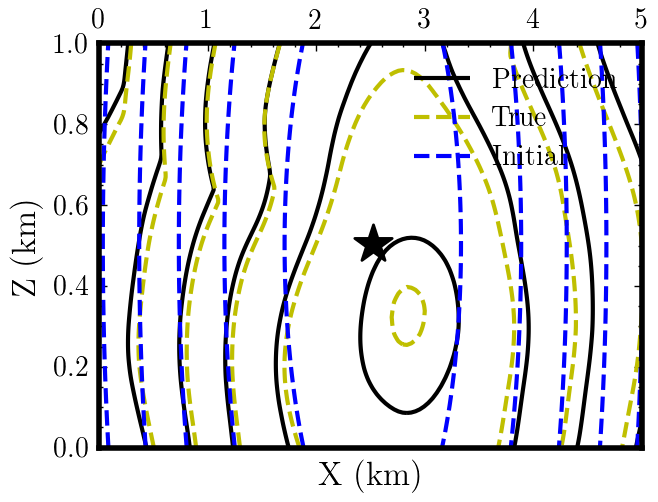

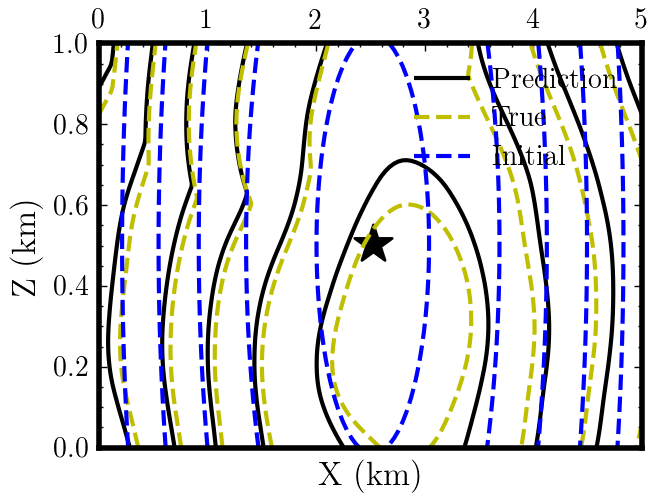

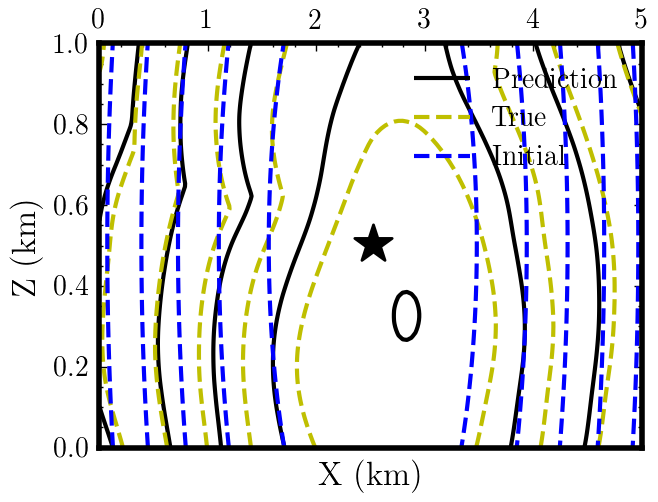

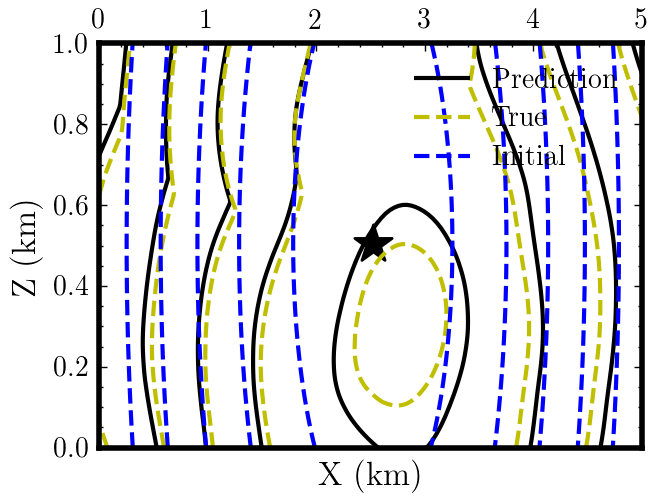

In [31]:
T_pred = tau_pred.reshape(Z.shape).detach().cpu() * T0.reshape(Z.shape)

# Numerical traveltime
T_fmm = numerical_traveltime3d(vel3d, len(x), len(y), len(z), len(id_sou), 
                                  xmin, ymin, zmin, deltax, deltay, deltaz, 
                                  [np.where(x==X.reshape(-1)[id_sou[i]])[0][0] for i in range(len(id_sou))], 
                                  [np.where(y==Y.reshape(-1)[id_sou[i]])[0][0] for i in range(len(id_sou))], 
                                  [np.where(z==Z.reshape(-1)[id_sou[i]])[0][0] for i in range(len(id_sou))])


for i in range(len(y)//5):
    plot_contour(
        T_pred[:,i,:], T_fmm[:,i,:,0], T0.reshape(Z.shape)[:,i,:], 
        0, len(x), len(z), len(sx), 
        sx, sz, x, z, fig_name='contour_y_'+str(y[i].round(2))+'.pdf', 
        save_dir=wandb_dir)